In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from Data.Featurisation import data_handeler
import numpy as np
import scienceplots
plt.rcdefaults()
plt.style.use(['science'])
avg_rmse = pd.read_pickle("evaluation/Target/avg_rmse.pkl")
avg_times = pd.read_pickle("evaluation/Target/avg_times.pkl")
rmse = pd.read_pickle("evaluation/Target/rmse.pkl")
time = pd.read_pickle("evaluation/Target/times.pkl")
time = time.loc[:,(slice(None), 'Training Time')]
sites = range(9)
models = [0,1,5,6,2,3,4,8,9]
model_labels = [r"$\text{Transf}_{np}$", r"$\text{Transf}_{p}$", r"$\text{Transf}_{nw}$",r"$\text{Targ}_{np}$", r"$\text{Targ}_{p}$",r"$\text{Transf}_{ra,np}$",
                 r"$\text{Transf}_{ra,p}$", "niks", "Phys", "Persis"]
import itertools
 
print(time)

one                0             1             2             3             4   \
two     Training Time Training Time Training Time Training Time Training Time   
one two                                                                         
0   0        1.648701       0.73853      6.809503       1.35395      2.395542   
    1        1.221879      1.243125      13.61837        3.3368      3.655778   
    2        1.747467      1.776594     20.415895      4.123009      5.272843   
    3        2.355875      2.380261     27.263735      5.481949       6.65952   
    4        2.879558      2.918782     34.036311      7.463693      7.891002   
...               ...           ...           ...           ...           ...   
8   8        5.176881      5.196375     60.425834     12.400702     14.579152   
    9         5.79407      5.796431     67.088655     13.777178      15.97326   
    10       6.315624      6.323772     73.863698     15.540689     17.208129   
    11       6.919682      6

In [44]:
rmse

0           1           2            3           4   \
one two                                                                
0   0    235.209457   233.59169  331.838501  1064.397461  1051.19397   
    1    247.160446  253.145096  334.543793   404.286102  250.650391   
    2    209.969894  214.964188  399.484161   226.627884  250.181671   
    3    234.128601  225.748291  298.160675    228.76355  240.389099   
    4    221.440079  225.494553  344.841675   250.181183  247.659409   
...             ...         ...         ...          ...         ...   
8   8    105.629265  104.939018   165.40274   108.132278  103.729218   
    9    142.687286  156.422394  226.289337   149.210434  150.672882   
    10   206.324738  211.073318  271.356689   221.287491  219.856262   
    11   189.994843  172.662277  233.833527   178.688492  173.240265   
    12    164.38121  149.814285  489.563568   126.621635  120.851196   

                 5           6           7           8           9    10   11  
one two                                                                        
0   0    282.325348  277.500732  229.066025  313.578351  379.309264  NaN  NaN  
    1    260.193512  262.692322   190.51416  356.005078  451.443297  NaN  NaN  
    2    218.499573  216.901535  188.089447  302.076247  484.204846  NaN  NaN  
    3    217.936539   219.84581   189.31366  309.160612   390.46213  NaN  NaN  
    4    218.957123  218.817322  165.659348  311.199138  429.733028  NaN  NaN  
...             ...         ...         ...         ...         ...  ...  ...  
8   8    111.778923  112.171494  112.171494   127.90306  213.586156  NaN  NaN  
    9    142.722351   140.58046   140.58046  158.133569  240.435123  NaN  NaN  
    10   219.788391  220.420242  220.420242   282.90126  319.751885  NaN  NaN  
    11   174.600128  174.103531  174.103531  316.218368  288.897288  NaN  NaN  
    12   150.333542  147.553009  147.553009  259.442304  681.200747  NaN  NaN  

[117 rows x 12 columns]

In [82]:
def calculate_skill_score(row):
    reference = row[9]
    skill_scores = {}
    for model in row.index[:-1]:  # Exclude the reference column
        model_rmse = row[model]
        skill_score = 1 - (model_rmse / reference)
        skill_scores[model] = skill_score
    return pd.Series(skill_scores)
rmse_NL = rmse.drop([2,3], level='two')
# Drop the last month
last_month = rmse_NL.index.get_level_values('two').max()
rmse_NL = rmse_NL.drop(last_month, level='two')
skill_scores = rmse_NL.apply(calculate_skill_score, axis=1)
skill_scores.reset_index(inplace=True)
skill_scores

KeyboardInterrupt: 

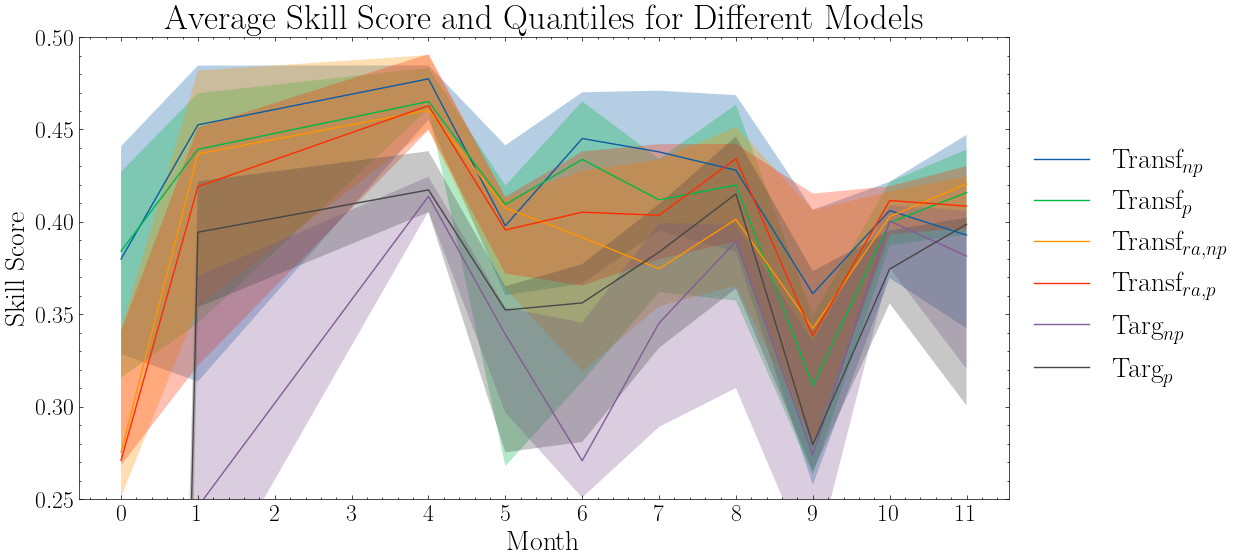

In [104]:
# Melt the DataFrame to long format for easier plotting with Seaborn
df_melted = skill_scores.melt(id_vars=['one', 'two'], var_name='Model', value_name='SkillScore')
# Calculate average and quantiles
summary = df_melted.groupby(['Model', 'two'])['SkillScore'].agg(median='median', q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)).reset_index()
# Plotting
plt.figure(figsize=(12, 6))
not_plot = [2,7,8,9,10]
models_plot = [x for x in models if x not in not_plot]
for i, model in enumerate(models_plot):
    model_data = summary[summary['Model'] == model]
    plt.plot(model_data['two'], model_data['median'], label=model_labels[model])
    plt.fill_between(model_data['two'], model_data['q25'], model_data['q75'], alpha=0.3)

plt.xlabel('Month', fontsize=20)
plt.ylabel('Skill Score', fontsize=20)
plt.ylim([0.25,0.5])
plt.title('Average Skill Score and Quantiles for Different Models', fontsize=25)
plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=20)
plt.yticks(fontsize=17)
plt.xticks(range(len(rmse.loc[0].index)-1), labels=range(len(rmse.loc[0].index)-1), fontsize=17)
plt.savefig("Figures/evaluation/NL_aggr_ss", dpi=200)
plt.show()

## Zero-shot accuracy

In [8]:
zero_shot_rmse = rmse.loc[(slice(None), 0), :]
zero_shot_rmse = zero_shot_rmse.droplevel(1)
zero_shot_rmse.astype(float).round(2).transpose()

one,0,1,2,3,4,5,6,7,8
0,235.21,191.59,547.38,255.31,205.65,204.24,189.76,201.27,216.30
1,233.59,223.28,555.26,228.77,210.73,177.27,191.51,199.91,220.95
2,331.84,267.04,557.76,264.64,295.44,264.60,276.70,297.43,266.85
3,1064.40,924.65,1247.88,576.13,984.86,868.63,799.30,829.86,773.80
4,1051.19,894.70,1256.60,573.19,959.78,849.97,792.01,794.05,765.13
5,282.33,261.25,558.06,268.33,241.91,220.39,221.08,185.69,230.50
6,277.50,255.06,573.50,284.36,237.71,221.73,221.37,193.64,229.07
7,229.07,229.07,229.07,229.07,229.07,229.07,229.07,229.07,229.07
8,313.58,251.49,963.08,308.56,284.46,236.12,272.39,220.06,327.69
9,379.31,348.88,688.91,287.18,367.84,304.17,336.00,367.22,322.88


In [9]:
(1-zero_shot_rmse.div(zero_shot_rmse[9], axis=0)).astype(float).round(4).transpose()

one,0,1,2,3,4,5,6,7,8
0,0.3799,0.4508,0.2054,0.1110,0.4409,0.3285,0.4352,0.4519,0.3301
1,0.3842,0.3600,0.1940,0.2034,0.4271,0.4172,0.4300,0.4556,0.3157
2,0.1252,0.2346,0.1904,0.0785,0.1968,0.1301,0.1765,0.1901,0.1735
3,-1.8061,-1.6504,-0.8114,-1.0062,-1.6774,-1.8558,-1.3789,-1.2598,-1.3965
4,-1.7713,-1.5645,-0.8240,-0.9959,-1.6092,-1.7944,-1.3572,-1.1623,-1.3697
5,0.2557,0.2512,0.1899,0.0656,0.3424,0.2754,0.3420,0.4943,0.2861
6,0.2684,0.2689,0.1675,0.0098,0.3538,0.2710,0.3412,0.4727,0.2906
7,0.3961,0.3434,0.6675,0.2024,0.3773,0.2469,0.3183,0.3762,0.2906
8,0.1733,0.2792,-0.3980,-0.0744,0.2267,0.2237,0.1893,0.4007,-0.0149
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## RMSE target

In [ ]:
#AVG RMSE
avg_rmse = pd.DataFrame(index=models, columns=sites)
for site in sites:
    _,_, eval_data = data_handeler(site, "nwp", "nwp", "nwp", transform=True)
    for model in models:  
        with open(f"DA_forecasts/DA_{model}_{site}", 'rb') as f:
            DA_forecast = pickle.load(f)
        
        power = eval_data['P']
        # if model in [3,4]:
        DA_forecast = DA_forecast[31*24:] #(30 days + 1 lag day)*24
        power = power[31*24:] 
        avg_rmse.loc[model, site] = np.sqrt(np.mean(np.square(DA_forecast-power)))
        
     

In [11]:
print(avg_rmse.astype(float).round(2))

        0       1       2       3       4       5       6       7       8
0  208.57  170.36  536.54  147.25  160.18  173.03  169.22  150.74  160.51
1  210.53  173.58  552.86  155.67  161.98  175.55  169.80  151.15  165.21
5  210.06  170.29  539.18  144.24  165.25  178.03  170.25  152.18  164.67
6  209.55  170.81  540.33  149.83  166.23  175.59  170.50  151.81  165.49
2  306.39  251.91  601.96  197.49  248.50  266.28  247.69  195.71  233.99
3  239.55  195.75  555.42  144.29  188.07  189.31  189.78  172.78  186.61
4  222.27  190.87  543.64  147.09  182.30  186.36  179.84  182.93  171.79
8  276.55  214.24  881.43  235.61  200.36  212.71  233.16  185.69  241.20
9  377.17  311.98  764.28  243.39  312.33  327.01  300.52  242.13  285.50


In [12]:
print((1-avg_rmse/avg_rmse.loc[9]).astype(float).round(4))

        0       1       2       3       4       5       6       7       8
0  0.4470  0.4539  0.2980  0.3950  0.4871  0.4709  0.4369  0.3774  0.4378
1  0.4418  0.4436  0.2766  0.3604  0.4814  0.4632  0.4350  0.3757  0.4213
5  0.4431  0.4542  0.2945  0.4074  0.4709  0.4556  0.4335  0.3715  0.4232
6  0.4444  0.4525  0.2930  0.3844  0.4678  0.4630  0.4327  0.3730  0.4203
2  0.1876  0.1925  0.2124  0.1886  0.2044  0.1857  0.1758  0.1917  0.1804
3  0.3649  0.3726  0.2733  0.4072  0.3979  0.4211  0.3685  0.2864  0.3464
4  0.4107  0.3882  0.2887  0.3957  0.4163  0.4301  0.4016  0.2445  0.3983
8  0.2668  0.3133 -0.1533  0.0320  0.3585  0.3495  0.2241  0.2331  0.1551
9  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000


C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\559221917.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\559221917.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\559221917.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\559221917.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


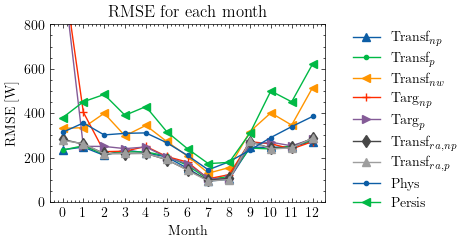

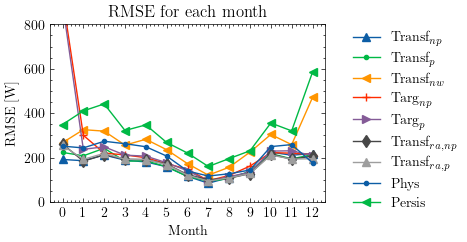

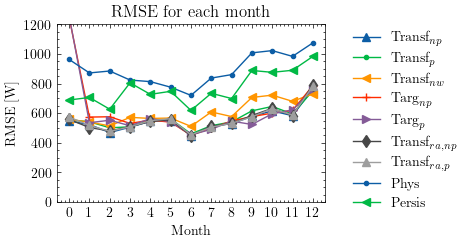

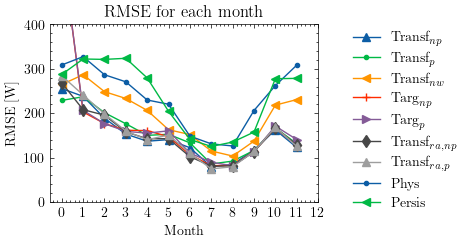

In [116]:
ymax = [800, 800, 1200, 400, 600,600,600,600,600]

for site in [0,1,2,3]:
    #RMSE
    marker = itertools.cycle(('^', '.', '<', '+', '>', 'd'))
    fig = plt.figure(site)
    for model in [0,1,2,3,4,5,6,8,9]:
        
        plt.plot(rmse.loc[(site, slice(None)), model].values, marker=next(marker), linestyle="-", label = model_labels[model])
    plt.ylim([0, ymax[site]])
    fig.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.title("RMSE for each month")
    plt.xlabel("Month")
    plt.ylabel("RMSE [W]")
    plt.xticks(range(len(rmse.loc[site].index)), labels=range(len(rmse.loc[site].index)))
    plt.tight_layout()
    plt.savefig(f"Figures/evaluation/rmse_month_s{site}")
    fig.show()

## Time Target

C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\2213294375.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\2213294375.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\2213294375.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\2213294375.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\2213294375.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\2213294375.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\2213294375.py:17: Us

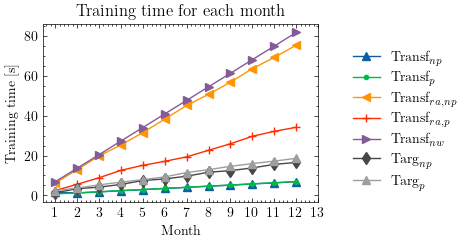

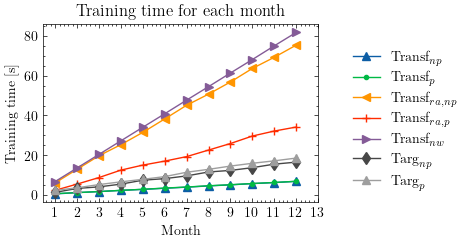

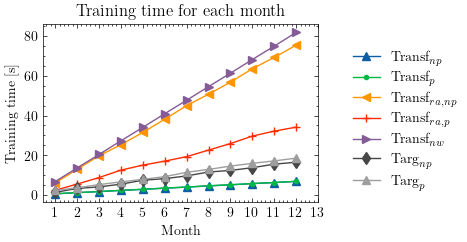

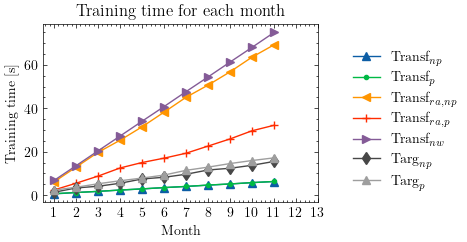

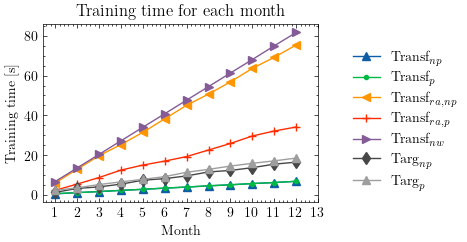

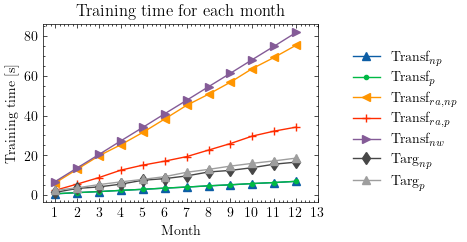

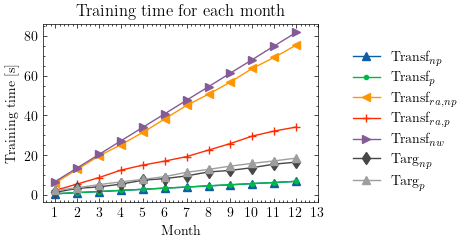

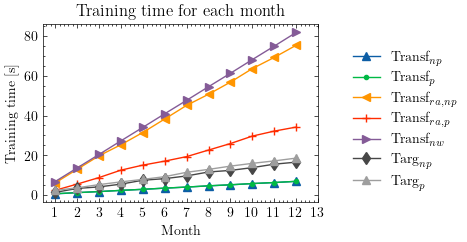

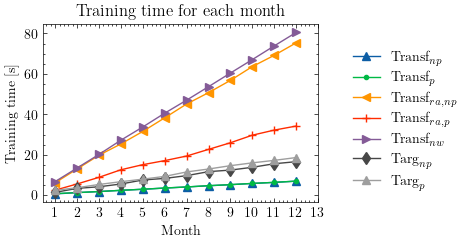

In [21]:
# ymax = [800, 800, 1200, 400]
for j, site in enumerate(sites):
    marker = itertools.cycle(('^', '.', '<', '+', '>', 'd'))
    #RMSE
    fig = plt.figure(site)
    for i, model in enumerate(models):
        if i <=6: 
            plt.plot(time.loc[(site, slice(None)), model].values, marker=next(marker), linestyle="-", label = model_labels[i])
    # plt.ylim([0, ymax[j]])
    fig.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel("Month")
    plt.ylabel("Training time [s]")
    plt.title("Training time for each month")
    plt.xticks(range(len(rmse.loc[site].index)), labels=range(1,len(rmse.loc[site].index)+1))
    plt.tight_layout()
    plt.savefig(f"Figures/evaluation/time_month_{site}")
    fig.show()

In [24]:
training = avg_times.loc[:, (slice(None), 'Training Time')].droplevel(1, axis=1).transpose()
inference = avg_times.loc[:, (slice(None), 'Inference Time')].droplevel(1, axis=1).transpose()

training.mean(axis=1).astype(float).round(2)

one
0      3.75
1      3.77
2     43.82
3      9.06
4     10.41
5     40.87
6     18.62
7     18.79
8       NaN
9       NaN
10      NaN
11      NaN
dtype: float64

In [26]:
inference.mean(axis=1).astype(float).round(8)

one
0     0.000251
1     0.000144
2     0.000282
3     0.000253
4     0.000240
5     0.000244
6     0.000240
7     0.000237
8     0.022033
9     0.000013
10         NaN
11         NaN
dtype: float64

## Skill score target

C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\1474210734.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\1474210734.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\1474210734.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_31260\1474210734.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


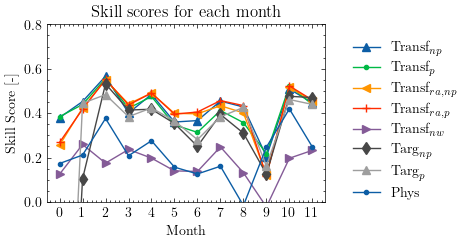

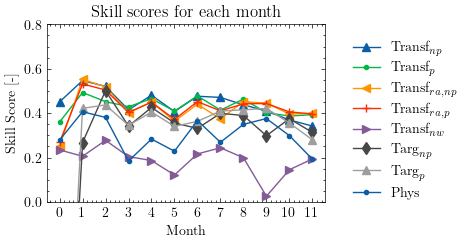

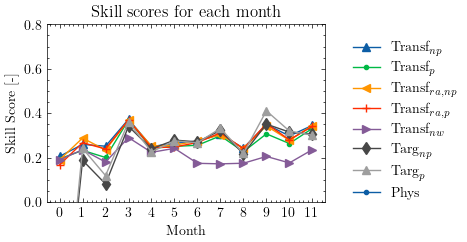

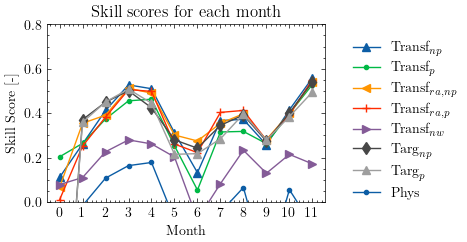

In [115]:
avg_skill_scores = pd.DataFrame(index=sites, columns=models)
for site in [0,1,2,3]:
    marker = itertools.cycle(('^', '.', '<', '+', '>', 'd'))
    persist = rmse.loc[(site, slice(None)), 9].values
    fig = plt.figure(site)
    for  model in models:
        if model != 9:
            rmse_mod_site = rmse.loc[(site, slice(None)), model].values
            ss = 1-  rmse_mod_site/persist
            ss= ss[:-1] #Dont select value for shorter month

            plt.plot(ss, marker=next(marker), linestyle="-", label = model_labels[model])
    plt.ylim([0, 0.8])
    fig.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel("Month")
    plt.ylabel("Skill Score [-]")
    plt.title("Skill scores for each month")
    plt.xticks(range(len(rmse.loc[site].index)-1), labels=range(len(rmse.loc[site].index)-1))
    plt.tight_layout()
    plt.savefig(f"Figures/evaluation/ss_month_{site}")
    fig.show()

## nRMSE Source

In [ ]:
#nRMSE
metrics =  pd.read_pickle("evaluation/source/metrics.pkl")
rmse_source = metrics.loc[:, (slice(None), "rmse")]
print(rmse_source)

lags = 24
forecast_period = 24
train_test_split = 0.8
source_models = [0,1,2,5,6]
for i in source_models:
    for j in range(4):
        rmse = rmse_source.loc[i,j].values
        if i <=4:
            data_name = "nwp"
        else: 
            data_name = "era5"
        if i in [1,6]:
            phys = True
        else:
            phys = False
        source_data,_, _ = data_handeler(j, data_name, "nwp", "nwp", phys)
        length = len(source_data.index)

        prediction_len = length - lags  # See how much data is used for predictions

        # The number of windows we have to predict depends on the length of the forecast window 
        # (we assume that the forecaster wants to forecast every upcoming period)
        windows = int(prediction_len / forecast_period)  # Get the number of predictions we can make.
        train_len = round(windows * train_test_split)  # Split the features into a train set...
        test_len = windows - train_len  # ... and a test set
        test = source_data.iloc[train_len*forecast_period+lags:]
        test_power = test['P']
        denominator = (test_power**2).mean()
        print(denominator)
        nRMSE = rmse/denominator


In [37]:
rmse_source = metrics.loc[:, (slice(None), "rmse")]
rmse_source.astype(float).round(2)

one,0,1,2,3,4,5,6,7,8
two,rmse,rmse,rmse,rmse,rmse,rmse,rmse,rmse,rmse
0,229.56,198.36,266.17,174.38,189.74,182.79,197.45,145.41,181.28
1,237.05,192.82,288.73,181.59,187.42,187.13,205.64,142.20,179.02
2,349.50,250.37,311.78,248.71,255.57,279.53,276.81,199.10,264.79
3,0.01,NaN,0.00,0.01,NaN,NaN,NaN,NaN,NaN
4,0.01,NaN,0.11,0.01,NaN,NaN,NaN,NaN,NaN
5,226.64,183.16,214.92,166.12,177.69,192.64,197.09,146.40,186.16
6,229.56,185.44,222.68,174.79,196.22,179.34,194.67,141.17,178.76
7,0.01,NaN,0.11,0.00,NaN,NaN,NaN,NaN,NaN
8,0.01,NaN,0.11,0.00,NaN,NaN,NaN,NaN,NaN


In [36]:
times_source= metrics.loc[:, (slice(None), "time")]
times_source.mean(axis=1).astype(float).round(2)

0     20.01
1     20.15
2     26.66
3     34.24
4     34.69
5     50.04
6     50.33
7     30.33
8     30.69
9       NaN
10      NaN
11      NaN
dtype: float64